Best alpha found by LassoCV: 1.655215

Test set performance:
                        rmse      r2
model                               
LinearRegression     53.8534  0.4526
Ridge(alpha=1.0)     53.7775  0.4541
Lasso(alpha=1.6552)  52.9196  0.4714

Number of coefficients exactly zero (Lasso): 3 / 10

Coefficients (rounded):

          Linear    Ridge    Lasso
feature                           
age       1.7538   1.8073   0.0000
sex     -11.5118 -11.4482  -7.9806
bmi      25.6071  25.7327  26.1857
bp       16.8289  16.7343  15.0418
s1      -44.4489 -34.6720  -4.8055
s2       24.6410  17.0531  -0.0000
s3        7.6770   3.3699 -11.0719
s4       13.1388  11.7643   0.0000
s5       35.1612  31.3784  21.9623
s6        2.3514   2.4581   1.7388



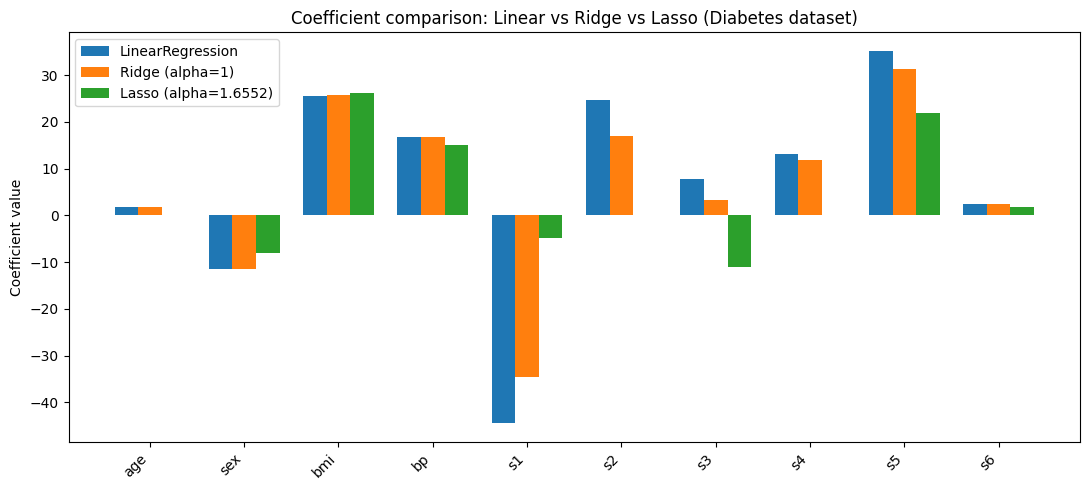

In [3]:
"""
Compare LinearRegression, Ridge, and Lasso on the scikit-learn Diabetes dataset.

- Standardizes features
- Uses LassoCV to choose alpha
- Prints test RMSE and R^2
- Prints coefficient table and number of zeros in Lasso
- Plots coefficient comparison
"""



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score

random_state = 42

# 1) Load dataset
data = load_diabetes()
X = data['data']
y = data['target']
feature_names = data.get('feature_names', [f'x{i}' for i in range(X.shape[1])])

# 2) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_state
)

# 3) Standardize features (important for Lasso/Ridge)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 4) Fit models
lr = LinearRegression().fit(X_train_s, y_train)
ridge = Ridge(alpha=1.0, random_state=random_state).fit(X_train_s, y_train)

# Use LassoCV to automatically pick alpha (search grid is internal)
lasso_cv = LassoCV(cv=5, random_state=random_state, max_iter=10000).fit(X_train_s, y_train)
best_alpha = lasso_cv.alpha_
lasso = Lasso(alpha=best_alpha, max_iter=10000).fit(X_train_s, y_train)

# 5) Evaluate on test set
models = {
    'LinearRegression': lr,
    'Ridge(alpha=1.0)': ridge,
    f'Lasso(alpha={best_alpha:.4f})': lasso
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test_s)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({'model': name, 'rmse': rmse, 'r2': r2})

results_df = pd.DataFrame(results).set_index('model')
print("Best alpha found by LassoCV: {:.6f}\n".format(best_alpha))
print("Test set performance:")
print(results_df.round(4))
print()

# 6) Coefficients table
coef_df = pd.DataFrame({
    'feature': feature_names,
    'Linear': lr.coef_,
    'Ridge': ridge.coef_,
    'Lasso': lasso.coef_
}).set_index('feature')

n_zero_lasso = int(np.sum(np.isclose(lasso.coef_, 0.0)))
print(f"Number of coefficients exactly zero (Lasso): {n_zero_lasso} / {X.shape[1]}")
print("\nCoefficients (rounded):\n")
print(coef_df.round(4))
print()

# 7) Plot coefficient comparison
plt.figure(figsize=(11, 5))
ind = np.arange(len(feature_names))
width = 0.25

plt.bar(ind - width, coef_df['Linear'], width, label='LinearRegression')
plt.bar(ind, coef_df['Ridge'], width, label='Ridge (alpha=1)')
plt.bar(ind + width, coef_df['Lasso'], width, label=f'Lasso (alpha={best_alpha:.4f})')

plt.xticks(ind, feature_names, rotation=45, ha='right')
plt.ylabel('Coefficient value')
plt.title('Coefficient comparison: Linear vs Ridge vs Lasso (Diabetes dataset)')
plt.legend()
plt.tight_layout()
plt.show()

